# EDA

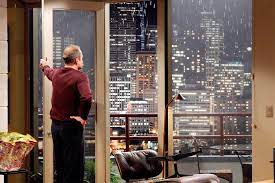

In [42]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
from dotenv import load_dotenv

#css
colors = {
    "beige": "#ecc9be",
    "lila": "#b81bc9",
    "orange": "#ff714b",
    "pink": "#ff52ff", 
    "rose" : "#ffd4fd"
}


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (5, 3),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Import Data with psycopg2 and dave as csv in data folder. 

In [ ]:
load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

cur = conn.cursor()

query_string = "SELECT * FROM eda.king_county_house_sales"
query_string2 = "SELECT * FROM eda.king_county_house_details"
df_psycopg = pd.read_sql(query_string, conn)
df_psycopg2 = pd.read_sql(query_string2, conn)

conn.close()

df_psycopg.to_csv('data/sales.csv',index=False)
df_psycopg2.to_csv('data/details.csv',index=False)

Understanding Data, what do we have here? 
- make df
- join sets
- check data

In [43]:
df_sales = pd.read_csv("data/sales.csv")
df_details = pd.read_csv("data/details.csv")

df_sales
df_details.head()
df = pd.merge(df_sales, df_details, left_on='house_id', right_on='id', how='outer')
df.drop(columns=["id_x", "id_y"], inplace=True)
# df.info()
# df.describe().T
# df.shape
# df.tail(10)



Observations: 
- data seems to be vollständig (not much nulls), exept years
- column names are correct (small letters and _), i droped doubled columns ids
- Bedrooms between 1 and 33 -> check later!
- größe in sqarefeet -> umrechnen!
- Avg living space fast 200m2 -> evt outlier checken


## Hypothesis

### Client

| Timothy Stevens     | Seller      | Owns expensive houses in the center, needs to get rid, best timing within a year, open for renovation when profits rise       | 
| ------------------- | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |                                  

### Question and Hypothesis
| Questions | Hytothesis|
| ------------------- | ----------- |
| When is the best time within the year to sell expensive houses in the city center for the highest possible profit? |  House prices in the city center peak during the spring and summer months due to increased demand.*|
||Houses listed during holiday seasons (like Thanksgiving or Christmas) take longer to sell and sell for lower prices because of reduced buyer activity.*|
||Houses listed in March sell fastest.*|
||Smaller newly renovated houses sell faster than larger ones|
||Bigger unrenovated houses sell faster than smaller ones|
|How does the potential for renovation impact the selling price for expensive houses in the center?| Renovated houses sell for a significantly higher price compared to similar houses without renovation.*|
|How does the potential for renovation impact the selling time to generate best prices|Houses that need renovation sell better early in the year, not during winter|
||The peak of sales for highest prices for renovated houses is different from unrenovated houses. |
|How did the prices of the City Center develop over the years? |The prices of property in the citycenter developed faster than outskirts or countyside over the last 10 years. *|

'* Hypothesis that needs to be discussed, the rest is optional


## Exploration

- Check distributions of the continuous variables, for example by producing histograms for each of them.
- Check the distributions for the categorical variables, by producing plots/tables of counts.
- Look at the histograms and check for clues or patterns: can you identify groups, are the distributions skewed, do you have extreme values or outliers, where is the data centered. Do you need to remove some data?

Text(0.5, 0, 'Number of Bedrooms')

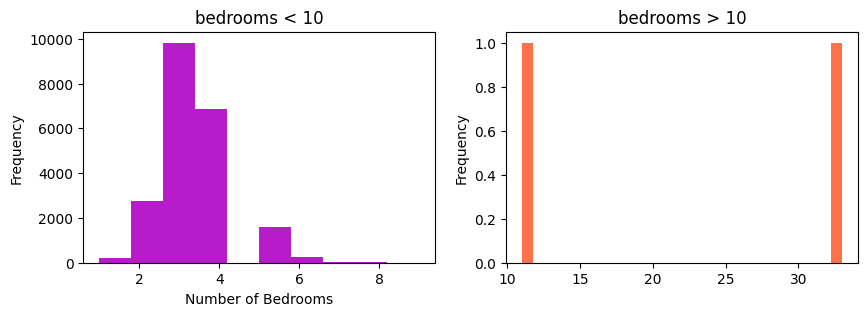

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

df[df.bedrooms <10].bedrooms.plot(kind="hist",ax=axes[0], color=colors["lila"], title="bedrooms < 10", bins=10)
axes[1].set_xlabel('Number of Bedrooms')
axes[1].set_ylabel('Frequency')

df[df.bedrooms >10].bedrooms.plot(kind="hist", ax=axes[1], color=colors["orange"], title="bedrooms > 10", bins=30)
axes[0].set_xlabel('Number of Bedrooms')


Text(0.5, 0, 'floors')

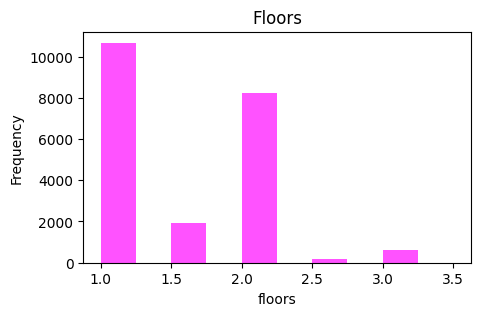

In [45]:

df[df.floors <10].floors.plot(kind="hist", color=colors["pink"], title="Floors")
plt.xlabel('floors')


Text(0.97, 0.84, '1-3: Falls short of minimum building standards. Normally cabin or inferior structure.\n4:  Generally older, low quality construction. Does not meet code.\n5: Low construction costs and workmanship. Small, simple design.\n6: Lowest grade currently meeting building code. Low quality materials and simple designs.\n7: Average grade of construction and design. Commonly seen in plats and older sub-divisions.\n8: Just above average in construction and design. Usually better materials in both the \n exterior and interior finish work.\n9: Better architectural design with extra interior and exterior design and quality.\n10: Homes of this quality generally have high quality features. Finish work is better and more design quality is \n seen in the floor plans. Generally have a larger square footage.\n11: Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and \n more luxurious options.\n12:  Custom design and excellent builders. All

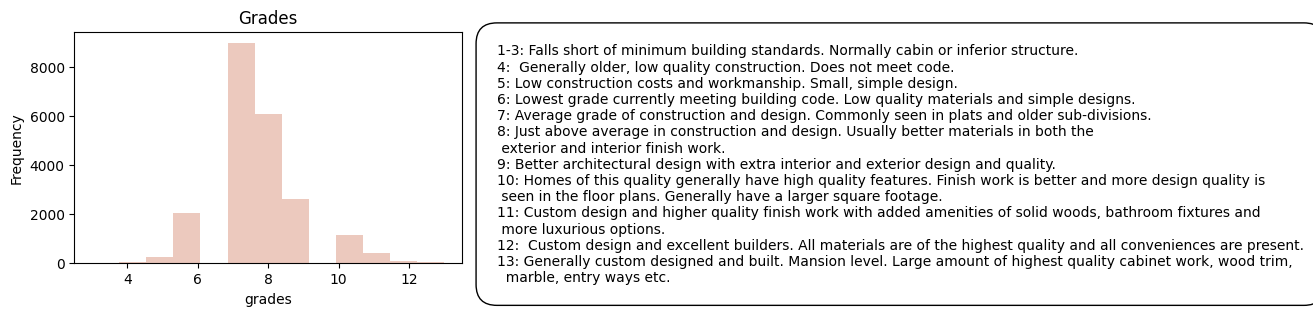

In [156]:
grade_labels={
"1-3": "Falls short of minimum building standards. Normally cabin or inferior structure.",
4:" Generally older, low quality construction. Does not meet code.",
5:"Low construction costs and workmanship. Small, simple design.",
6 :"Lowest grade currently meeting building code. Low quality materials and simple designs.",
7 :"Average grade of construction and design. Commonly seen in plats and older sub-divisions.",
8 :"Just above average in construction and design. Usually better materials in both the \n exterior and interior finish work.",
9 :"Better architectural design with extra interior and exterior design and quality.",
10 :"Homes of this quality generally have high quality features. Finish work is better and more design quality is \n seen in the floor plans. Generally have a larger square footage.",
11 :"Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and \n more luxurious options.",
12:" Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.",
13 :"Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim,\n  marble, entry ways etc.",
}


df.grade.plot(kind="hist", color=colors["beige"], title="Grades", bins=13 )
plt.xlabel('grades')

legend_text = "\n".join([f"{k}: {v}" for k, v in grade_labels.items()])

plt.gcf().text(0.97, 0.84, legend_text, fontsize=10, va='top', ha='left', bbox=dict(boxstyle='round,pad=1.5', facecolor='white'))



Text(1, 0.5, ' 1: Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating \n  and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, \n  approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the  \n  end of the scale regardless of the actual chronological age.\n 2: Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, \n deferred maintenance obvious, inadequate building utility and systems all  \n  shortening the life expectancy and increasing the effective age.\n 3: Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor \n repairs are needed, along with some refinishing. All major components still functional and contributing toward \n an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.\n 4: Good- No obvious maintenan

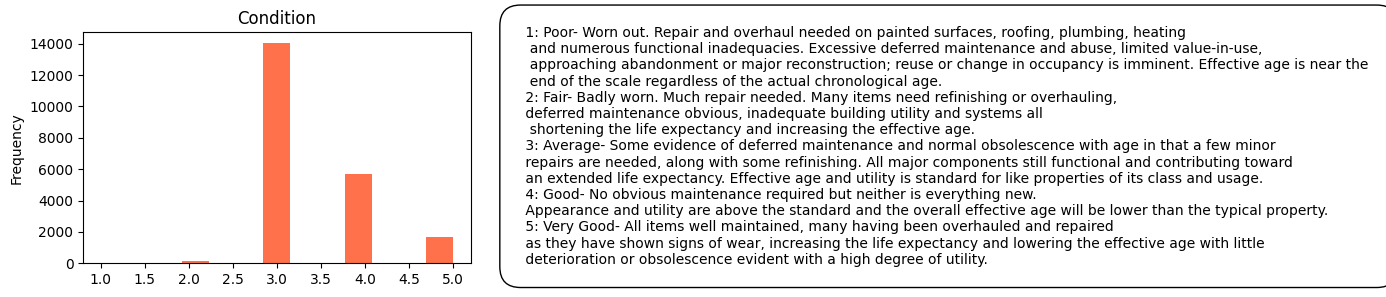

In [181]:
conditions={
1 : "Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating \n  and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, \n  approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the  \n  end of the scale regardless of the actual chronological age.",
2 : "Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, \n deferred maintenance obvious, inadequate building utility and systems all  \n  shortening the life expectancy and increasing the effective age.",
3 : "Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor \n repairs are needed, along with some refinishing. All major components still functional and contributing toward \n an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.",
4 : "Good- No obvious maintenance required but neither is everything new.\n Appearance and utility are above the standard and the overall effective age will be lower than the typical property.",
5: "Very Good- All items well maintained, many having been overhauled and repaired \n as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little \n deterioration or obsolescence evident with a high degree of utility.",
}

df.condition.plot(kind="hist", color=colors["orange"], title="Condition", bins=13)

conditions_text = "\n".join([f" {k}: {v}" for k, v in conditions.items()])

plt.gcf().text(1, 0.5, conditions_text, fontsize=10, va='center', ha='left', bbox=dict(boxstyle='round,pad=1.5', facecolor='white'))

## Data Cleaning
Year renovated is in  20130.000 wired shape. 
- Cut the float and one 0 at the end to get a year. Only if len > 4 
- drop all entries that are not a valid year number, make them to 0

In [46]:

df["yr_renovated"] = df['yr_renovated'].fillna(0).astype(int)
df["yr_renovated"] = df["yr_renovated"].astype(str).apply(lambda x: x.rstrip('0') if len(x) > 4 else x)
df["yr_renovated"] = df["yr_renovated"].replace('', '0').astype(int)

# make all entries len < 4 to 0
df.loc[(df['yr_renovated'] != 0) & (df['yr_renovated'].notna()) & 
       (df['yr_renovated'].astype(str).apply(lambda x: len(x) < 4)), 'yr_renovated'] = 0

#655 entries for renovation
df["yr_renovated"][df["yr_renovated"].astype(str).apply(lambda x: len(x) == 4)].count()





np.int64(655)

- make float to int 

In [182]:
df.bedrooms = df.bedrooms.astype(int)
df.floors = df.floors.astype(int)
df.bathrooms = df.bathrooms.astype(int)
df.head(10)
df.columns

Index(['date', 'price', 'house_id', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')